# Interpreting LOO-PIT

![loo-pit](cover.png)

I got a question about interpreting plots you get from [Arviz](https://arviz-devs.github.io/). This particular one was about LOO-PIT which you can find [here](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_loo_pit.html).

## Integral transform

First, we need a model to demonstrate the pathologies that can be diagnosed with the LOO-PIT. I will use linear regression with robust likelihood to show all possible cases that can be fixed just by looking at the plot.

But wait, what is LOO-PIT you ask? Ok, let's give some theory before we start.

* LOO stands for Leave One Out validation. We usually want LOO to cross-validate our model. We train it on all but the one observation and then make predictions on the one that was the holdout. The same for every single observation.
* PIT stands for Probability Integral Transformation. Briefly, it transforms any continuous distribution into a Uniform distribution.

While it is relatively clear what is LOO, it is not super clear, what is PIT. Let's make some visualizations.

In [1]:
import scipy.stats
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import warnings
import pymc as pm
warnings.filterwarnings("ignore")

In [2]:
student_t = scipy.stats.t(df=5)
uniform = scipy.stats.uniform()

$$
\begin{align}
t &\sim \operatorname{StudentT}(0, 1)\\
u &= \operatorname{StudentT}(0, 1)\operatorname{.cdf}(t)\\
u &\sim \operatorname{Uniform}[0, 1]
\end{align}
$$

In [3]:
t = student_t.rvs(size=10000)
u = student_t.cdf(t)

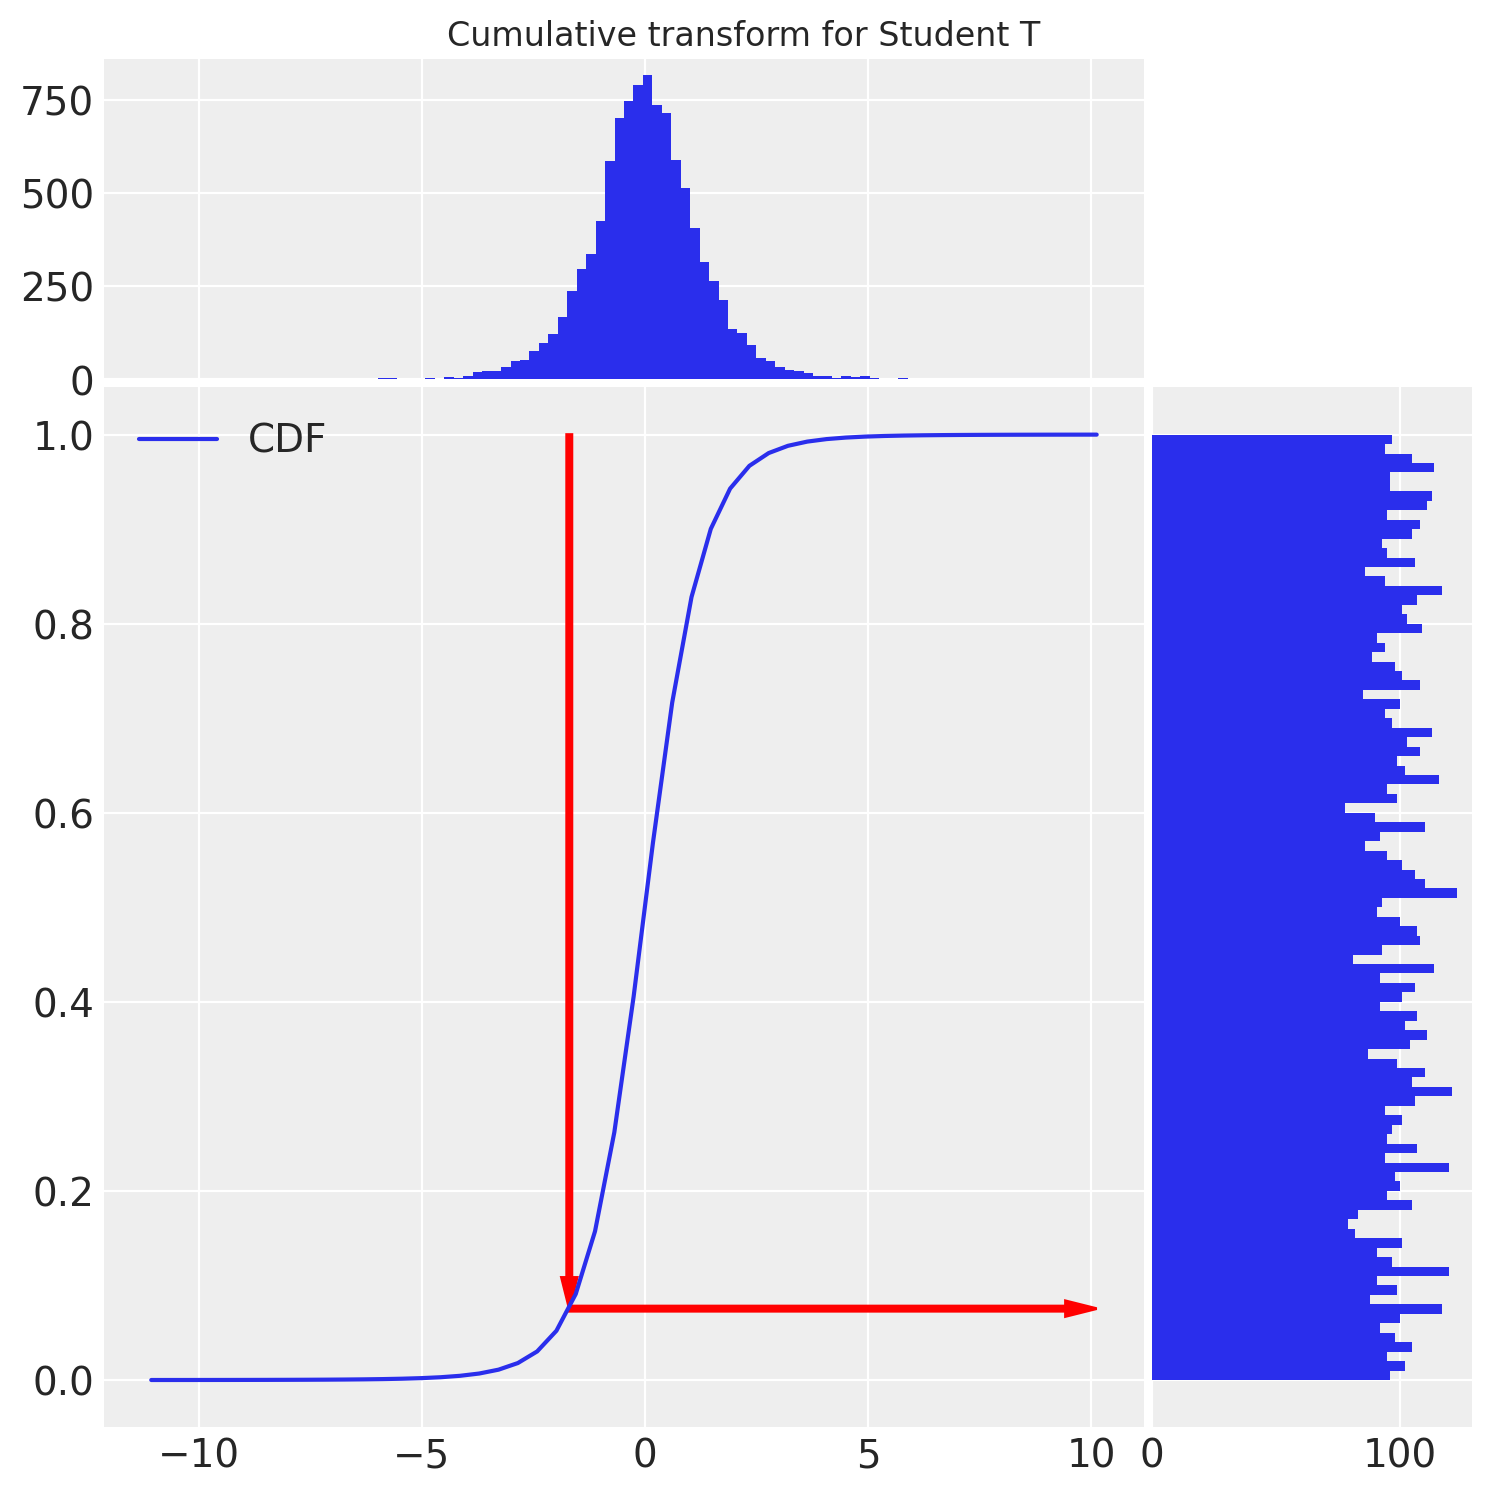

In [46]:
def scatter_hist(dist1, dist2, ax, ax_histx, ax_histy, n=10000):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    np.random.seed(50)
    x = dist1.rvs(size=n)
    y = dist1.cdf(x)
    r = np.linspace(min(x), max(x))
    ax.plot(r, dist1.cdf(r), label="CDF")
    ax.arrow(x[0], 1, 0, y[0]-1, 
             length_includes_head=True,
             width=0.005 * (ax.get_xlim()[1]-ax.get_xlim()[0]),
             head_length=0.03 * (ax.get_ylim()[1]-ax.get_ylim()[0]),
             color="r"
            )
    ax.arrow(x[0], y[0], max(x)-x[0], 0, 
             length_includes_head=True,
             width=0.005 * (ax.get_ylim()[1]-ax.get_ylim()[0]),
             head_length=0.03 * (ax.get_xlim()[1]-ax.get_xlim()[0]),
             color="r"
            )
    ax_histx.hist(x, bins=100)
    ax_histy.hist(y, bins=100, orientation='horizontal')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(student_t, uniform, ax, ax_histx, ax_histy);
ax.legend()
plt.suptitle("Cumulative transform for Student T");

We see that the cumulative transform does the job and transforms our StudentT random variables to the Uniform distribution. Similar ideas are used for LOO-PIT.

1. [Compute](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/stats/stats.py#L1674) pointwise likelihood for all the observations
2. [Calculate](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/stats/stats.py#L770) LOO likelihood approximation using [pareto smoothed importance sampling](https://arxiv.org/abs/1507.02646)
3. [Approximate](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/stats/stats.py#L1729) ECDF (Empirical CDF) values of the posterior predictive (for each sample)
4. [Approximate](https://github.com/arviz-devs/arviz/blob/9d0746972c9bcb1a3063c0ca00ff08a0b0c093ee/arviz/plots/loopitplot.py#L177) the ECDF function for visualization with KDE

If the likelihood is well specified, we'll see a uniform distribution of ECDF values, means, uniform KDE. Just like on the plot above

# Case study
## Generative model
Our data will be generated with student T likelihood. We can adjust the degrees of freedom in the model to take care of the noise magnitude. This example will also be a very good way to visualize pathologies

In [5]:
def model(x, y, Likelihood: callable):
    """
    Parameters
    ----------
    x: np.ndarray
    y: np.ndarray
    Likelihood: callable
        defines the likelihood of the observed variables
        given y and y_hat as keywords. Here is an example
        
        .. code-block:: python
            
            Likelihood = lambda name, y, y_hat: pm.Normal(name, y_hat, observed=y)
    """
    with pm.Model() as m:
        x = pm.Data("x", x)
        y = pm.Data("y", y)
        β = pm.Normal("β")
        intercept = pm.HalfCauchy("intercept", 1.)
        y_hat = intercept + β * x
        Likelihood("y_obs", y_hat=y_hat, y=y)
    return m

### Generating example data
I do not think our data or model should be complicated. 
The whole point of the LOO-PIT is in defining likelihood, rarely model structure or flexibility. We can easily illustrate this with a univariate linear regression.

In [6]:
true_beta = 1.2
true_intercept = 15
true_nu = 2
true_sigma = 3

In [7]:
np.random.seed(42)
x = scipy.stats.uniform.rvs(0, 30, size=1000)
y = scipy.stats.t.rvs(true_nu, true_intercept + x * true_beta, true_sigma)

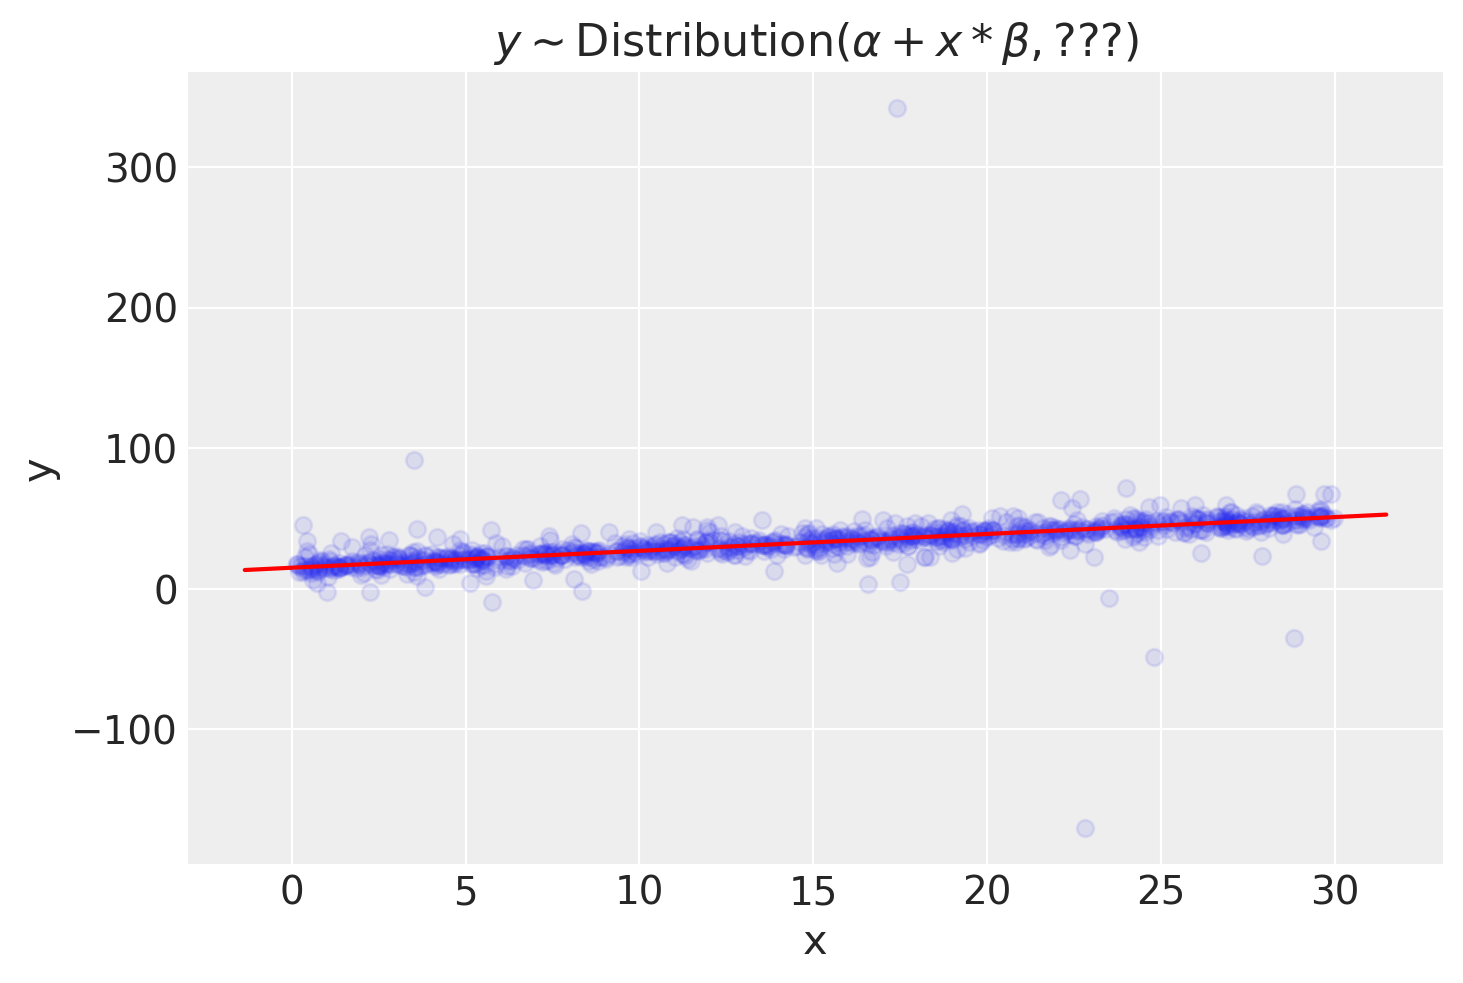

In [8]:
plt.scatter(x, y, alpha=0.1);
plt.plot(np.linspace(*plt.xlim()), true_intercept + np.linspace(*plt.xlim()) * true_beta, color="r")
plt.title(r"$ y \sim \operatorname{Distribution}(\alpha + x * \beta, ???)$");
plt.xlabel("x")
plt.ylabel("y");

## Bayesian detective
### Normal likelihood
Most of the models start simple. The simple model in our case starts with a Normal likelihood.

In [9]:
NormalLik = lambda name, y, y_hat: pm.Normal(
    name, y_hat, 
    sigma=pm.HalfNormal("sigma"), observed=y
)

In [10]:
with model(x, y, NormalLik) as normal_model:
    normal_trace = pm.sample(idata_kwargs=dict(log_likelihood=True))
    normal_trace.extend(pm.sample_posterior_predictive(normal_trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y_obs]


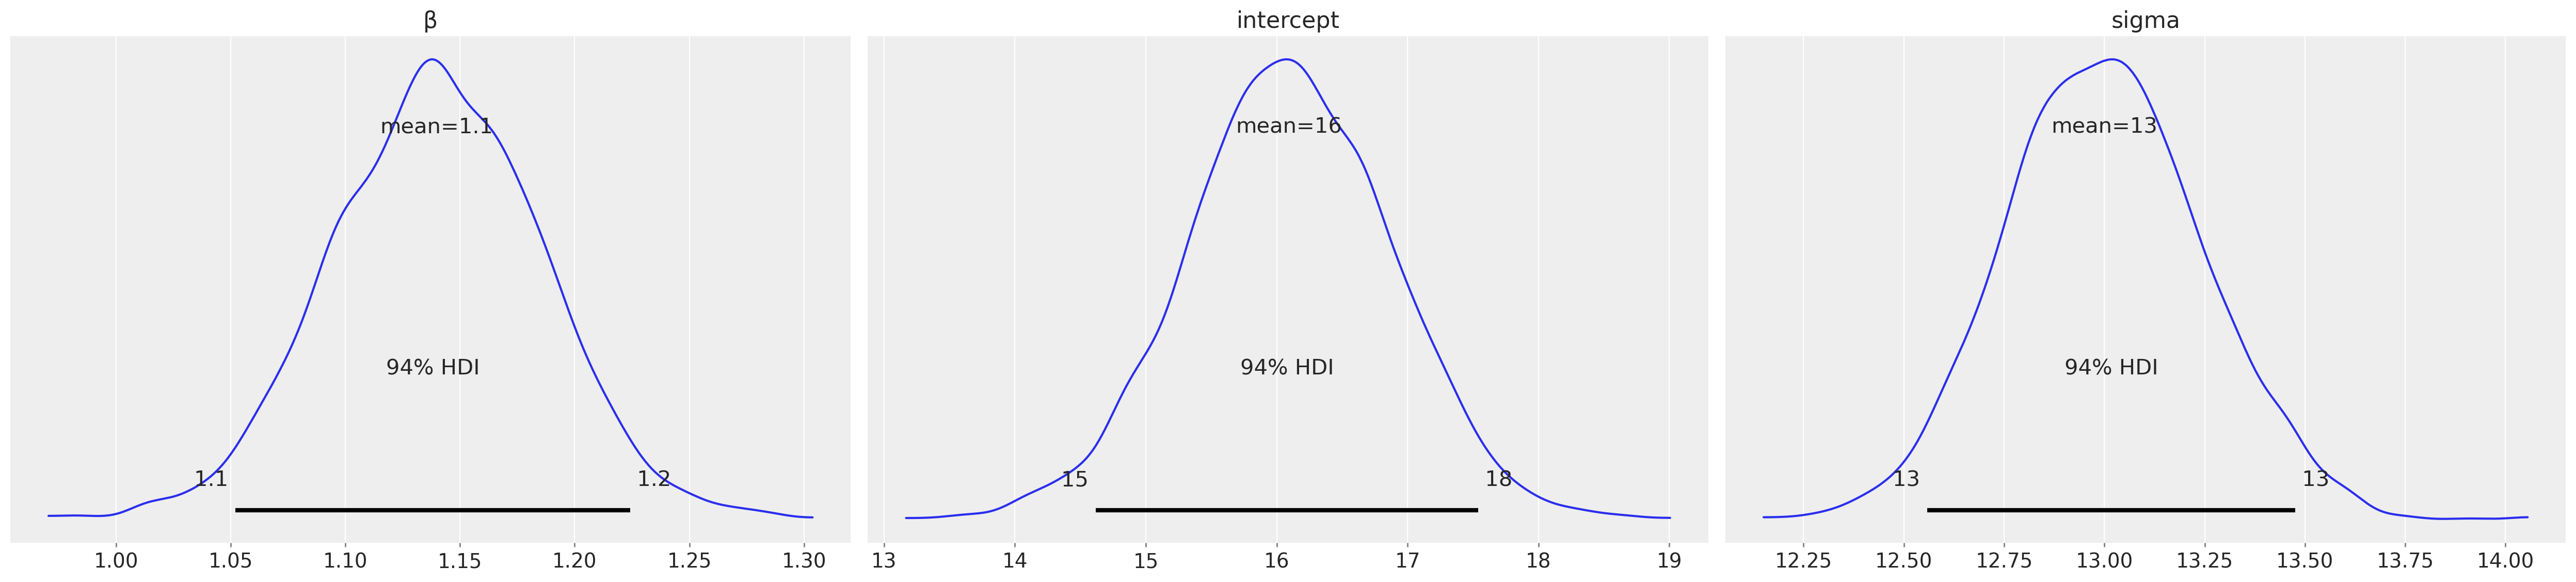

In [11]:
az.plot_posterior(normal_trace);

#### Checks
> You know nothing about the underlying true model, so I'll keep the intrigue about posterior vs true values to the end.

Let's look at LOO-PIT

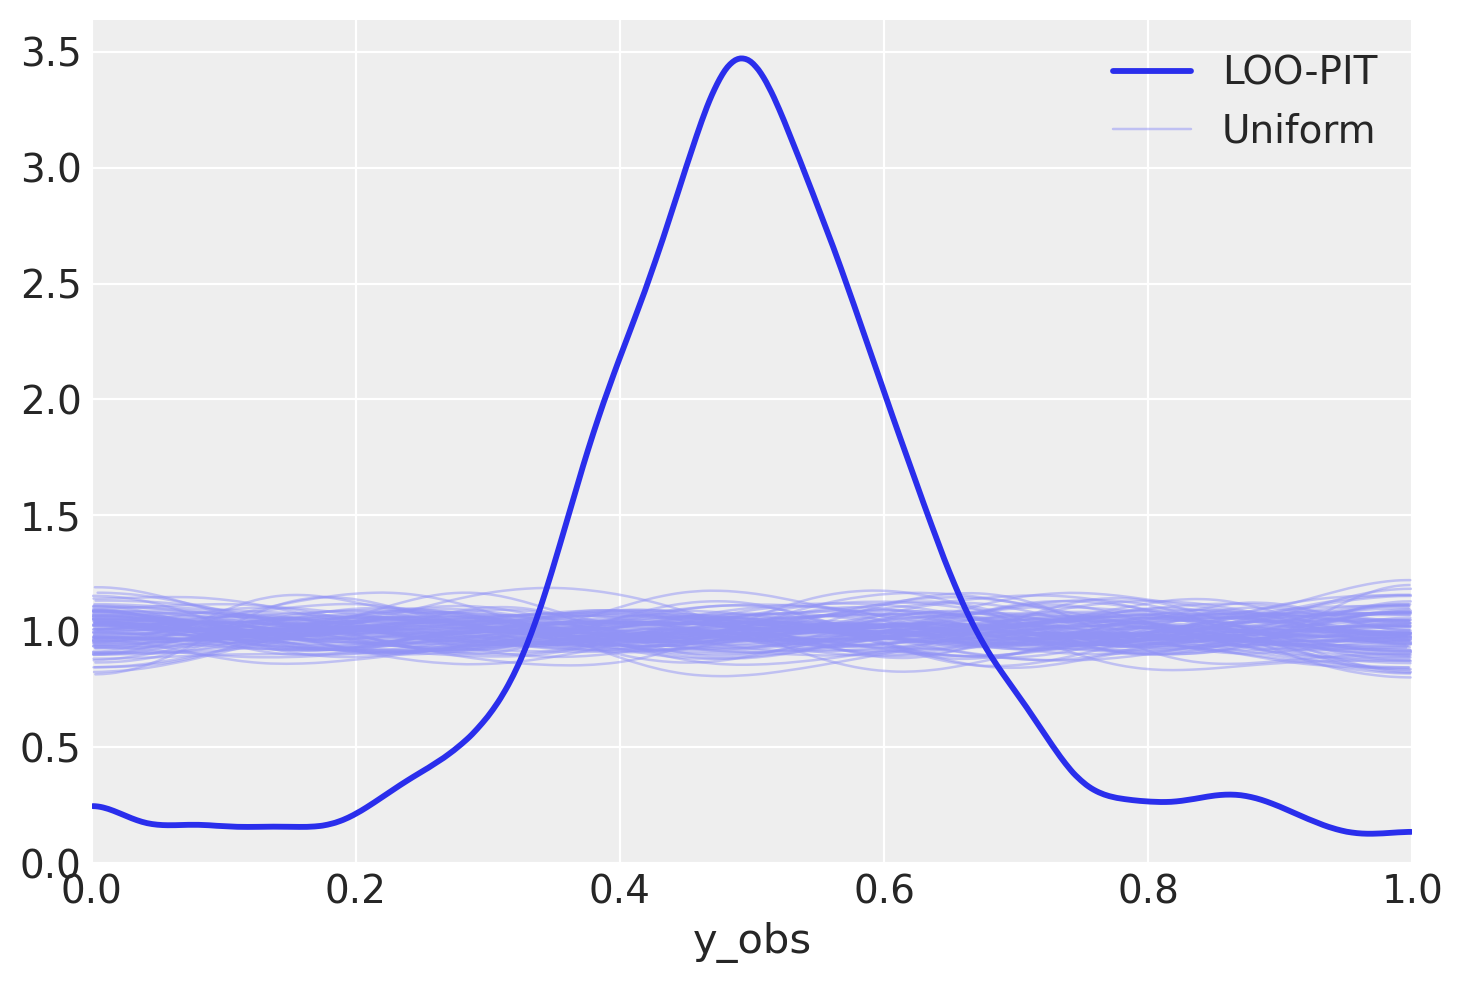

In [12]:
az.plot_loo_pit(normal_trace, "y_obs");

> Disclaimer. I write these lines as I would first see it, without conducting further analysis. This gives you a good thought process happening in my head.

Oh, you might think! Something is going wrong. What do we read from the plot? Let's operate with facts:
* We have to recall that what we plot here is CDF of the posterior applied to the observed data
* Since we specified normal distribution in likelihood our CDF has similar properties (no outliers)
* Looks like our data is mostly concentrated inside the high-density region and not represented on the tails

*I know how I generated my data and, actually, expected a bit different picture. But let's see how it goes*

Let's check how does the posterior predictive looks like:

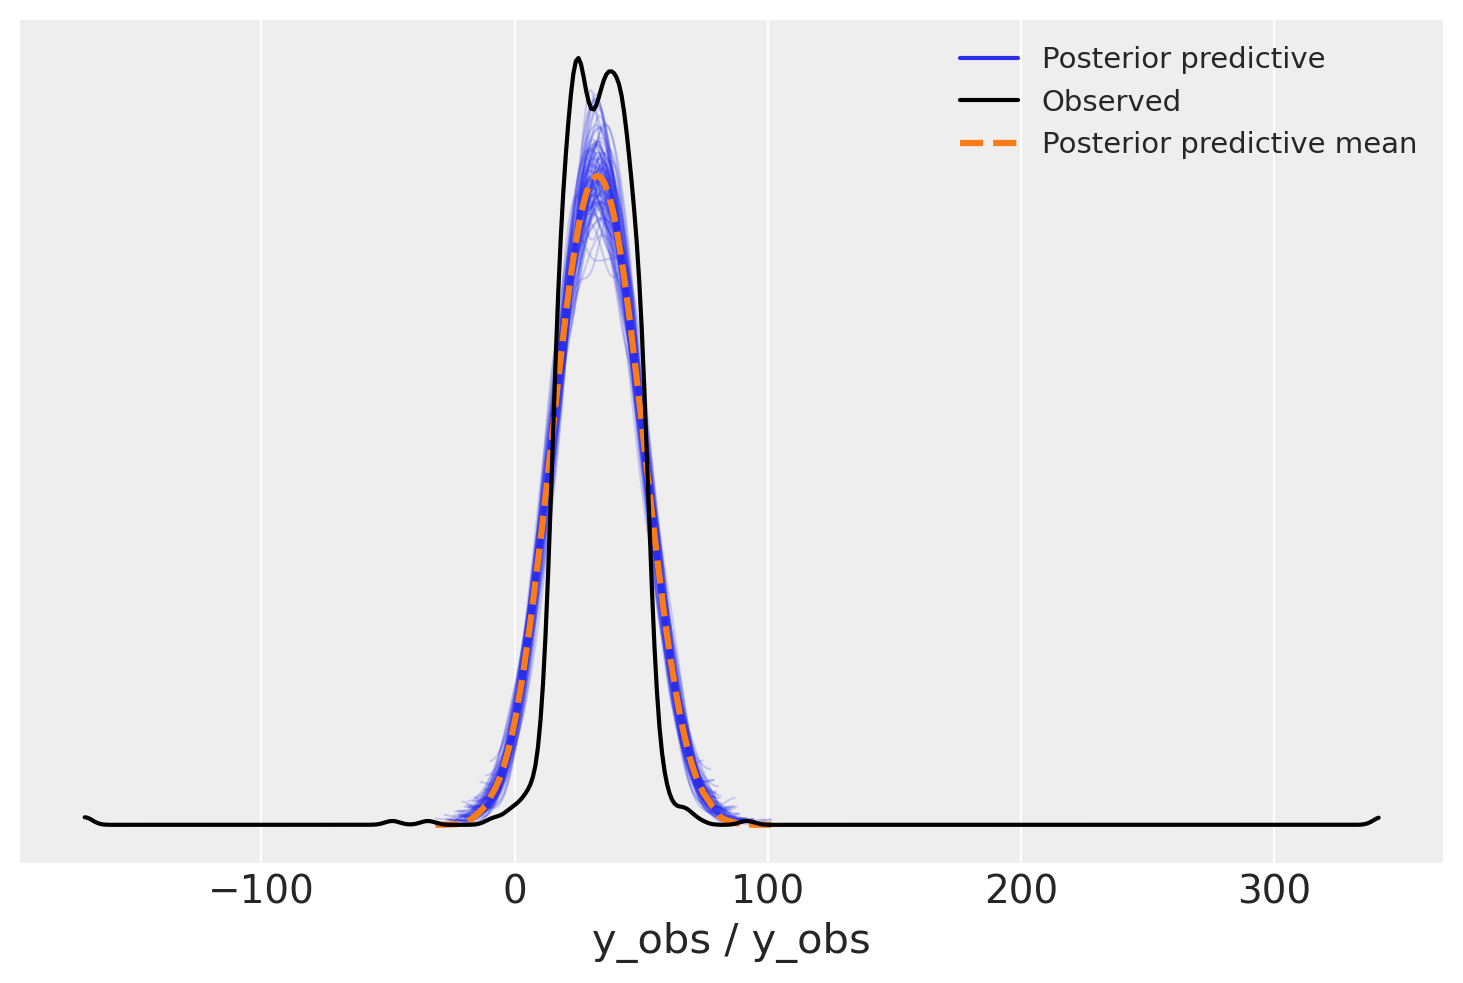

In [13]:
az.plot_ppc(normal_trace, num_pp_samples=100);

Oh, yeah! We get some more intuition from this picture. Data has huge tails, but narrow high-density regions. But for a more complicated distribution, could we have known that we have outliers without the picture? Yes

In [14]:
az.loo(normal_trace, pointwise=True)

Computed from 4000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4112.17   343.11
p_loo       91.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      998   99.8%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    2    0.2%

With Pareto k diagnostic values we see that we have two outliers. I would not say that two is good. Our example says that we have a very ill-defined model. But only by combining the LOO-PIT check and Pareto k values we can conclude that with symptoms we observe the disease are outliers.

> But only combining LOO-PIT check and Pareto k values we can conclude that with symptoms we observe the disease are outliers.

* Could we do more plots? Yes
* Would they add more value? Probably
* How much? Not much

### Robust likelihood
Let's go to the second specification of our model. This one will be robust, amazingly robust, we'll try to get as long tails as possible.

In [15]:
OverdispersedPrior = lambda name, y, y_hat: pm.Cauchy(
    name, y_hat, pm.HalfNormal("sigma", 1), observed=y
)

And then use it in the model

In [16]:
with model(x, y, OverdispersedPrior) as overdispersed_model:
    overdispersed_trace = pm.sample(idata_kwargs=dict(log_likelihood=True))
    overdispersed_trace.extend(pm.sample_posterior_predictive(overdispersed_trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y_obs]


#### Checks

Let's check LOO-PIT again

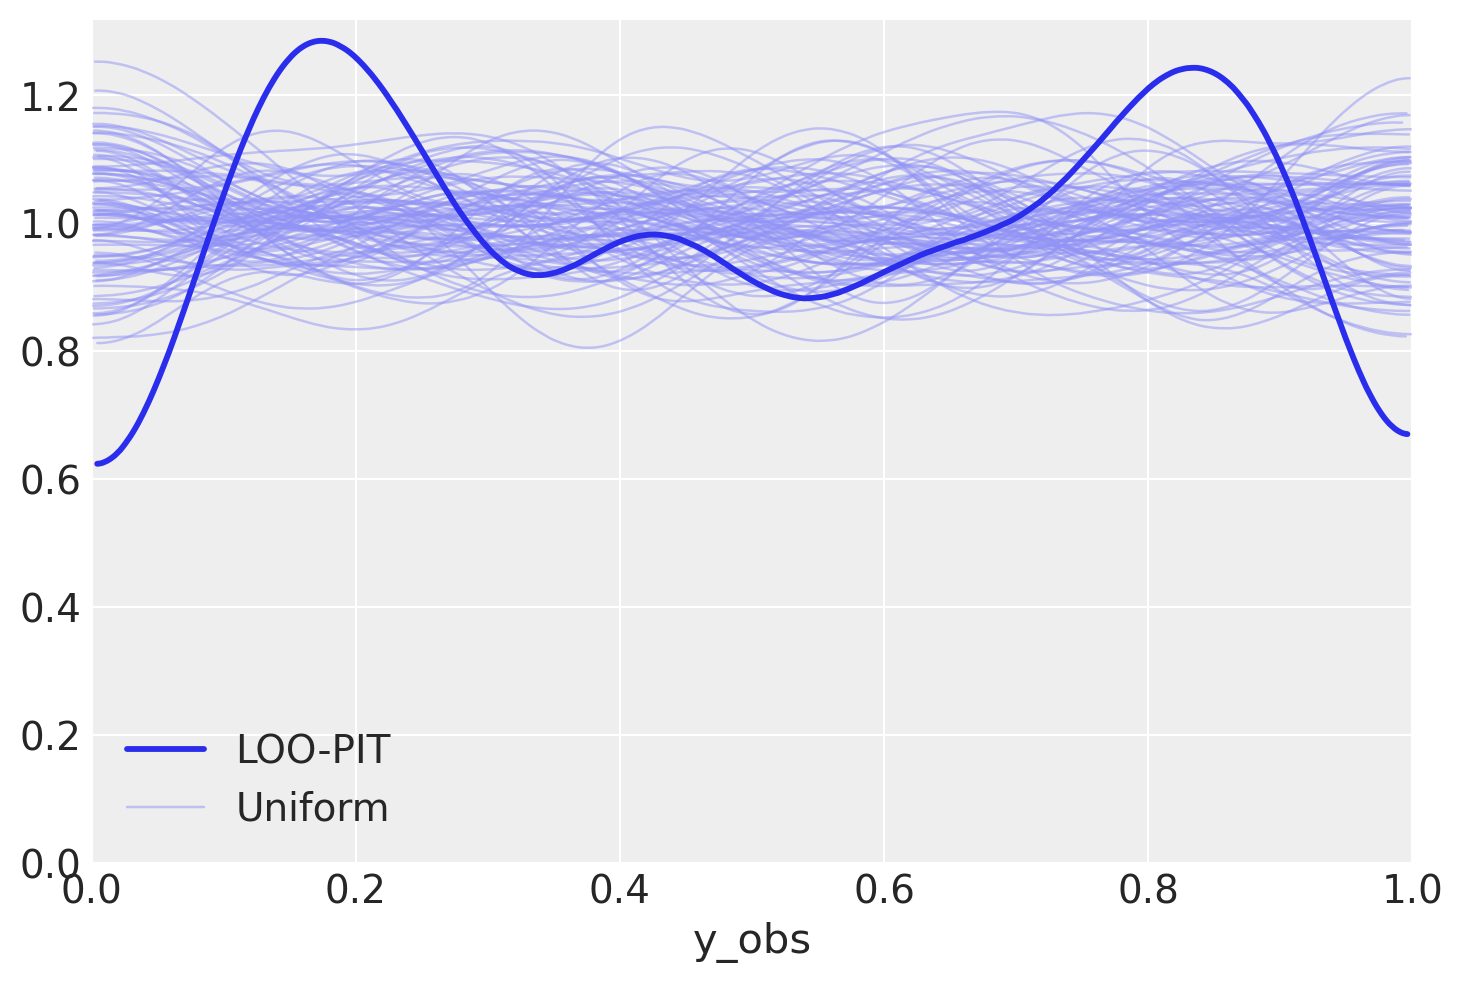

In [19]:
az.plot_loo_pit(overdispersed_trace, "y_obs");

Ok, we now see two weird bumps in the LOO-PIT plot. What can we say about this?
* Remember, these are CDF values of data
* Yeah, CDF says that in high-density region we have less observations than on tails
* Let me clarify a tiny bit

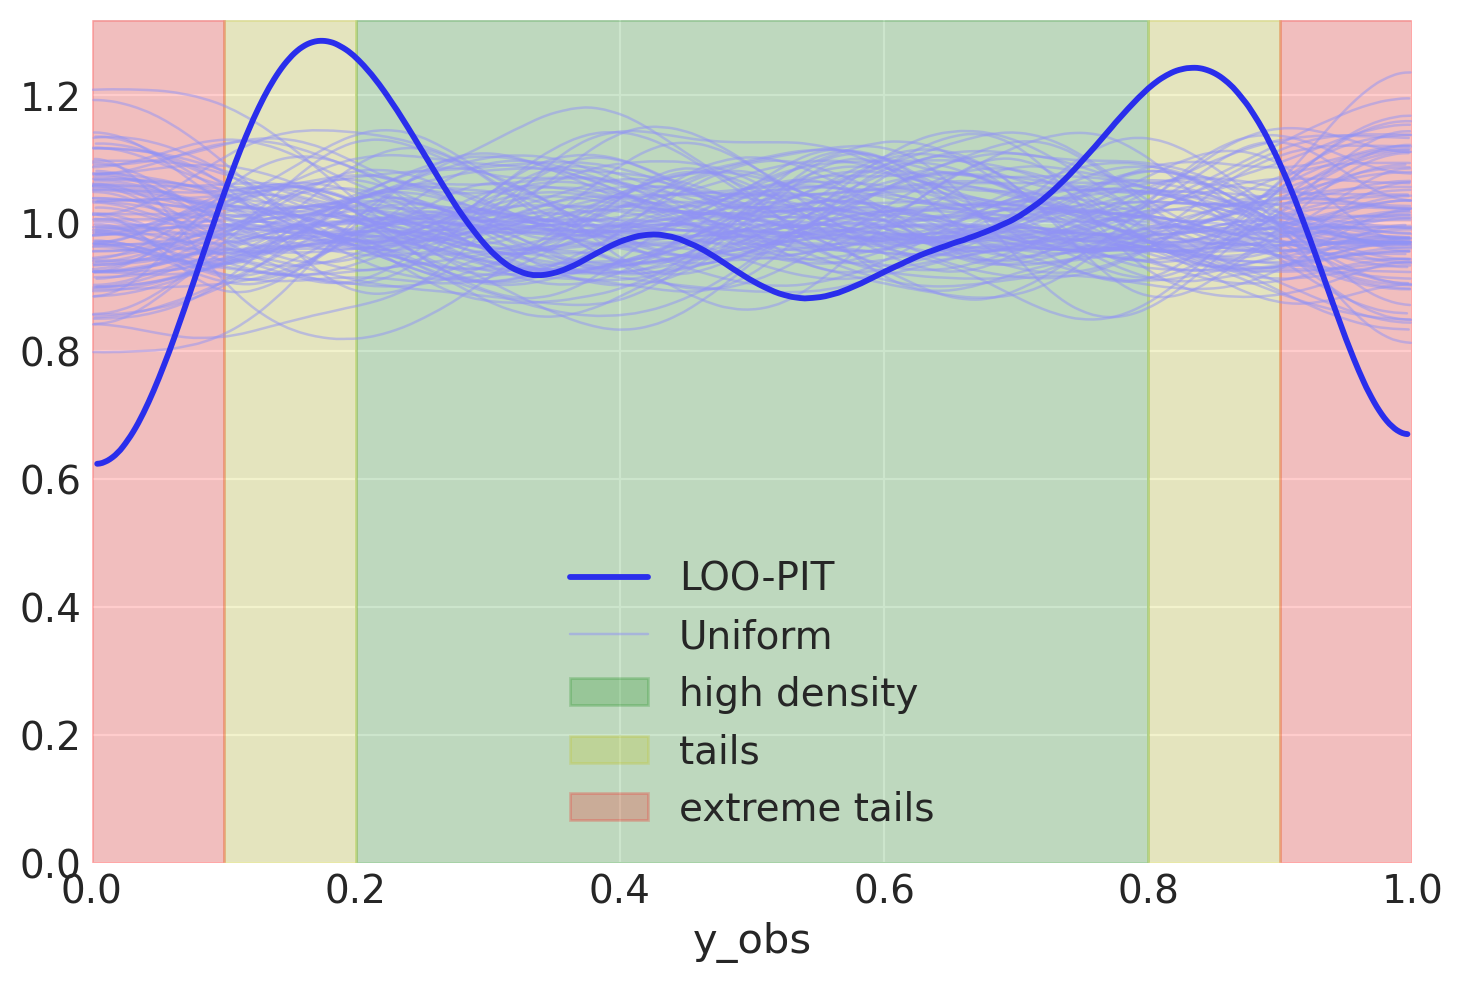

In [20]:
az.plot_loo_pit(overdispersed_trace, "y_obs")
plt.axvspan(0.2, 0.8, color="g", alpha=.2, label="high density")
plt.axvspan(0.1, 0.2, color="y", alpha=.2, label="tails")
plt.axvspan(0.8, 0.9, color="y", alpha=.2)
plt.axvspan(0.0, 0.1, color="r", alpha=.2, label="extreme tails")
plt.axvspan(0.9, 1.0, color="r", alpha=.2)
plt.legend();

Data seems to be clearly concentrated a bit far from where it should be. We probably underestimated variance - we do not see enough data in the small green region. Let's check the PPC plot to visualize the intuition further.

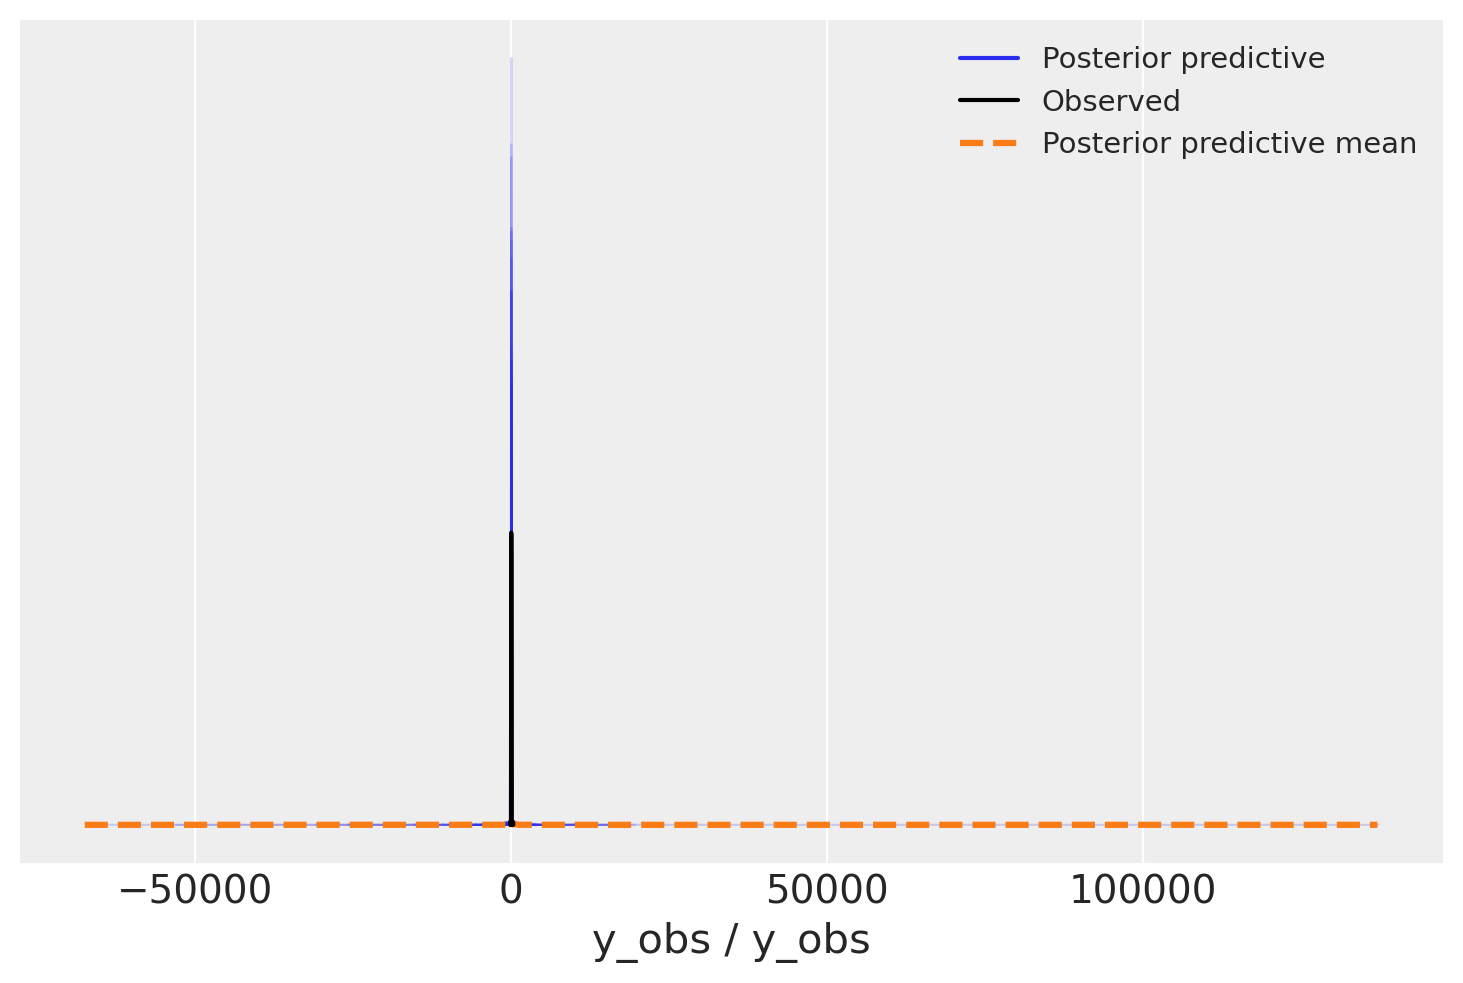

In [21]:
az.plot_ppc(overdispersed_trace, num_pp_samples=100);

Oh, what a bad model would you say, outliers are insane in the posterior predictive, we should have less of them. But wait, what about variance, not outliers

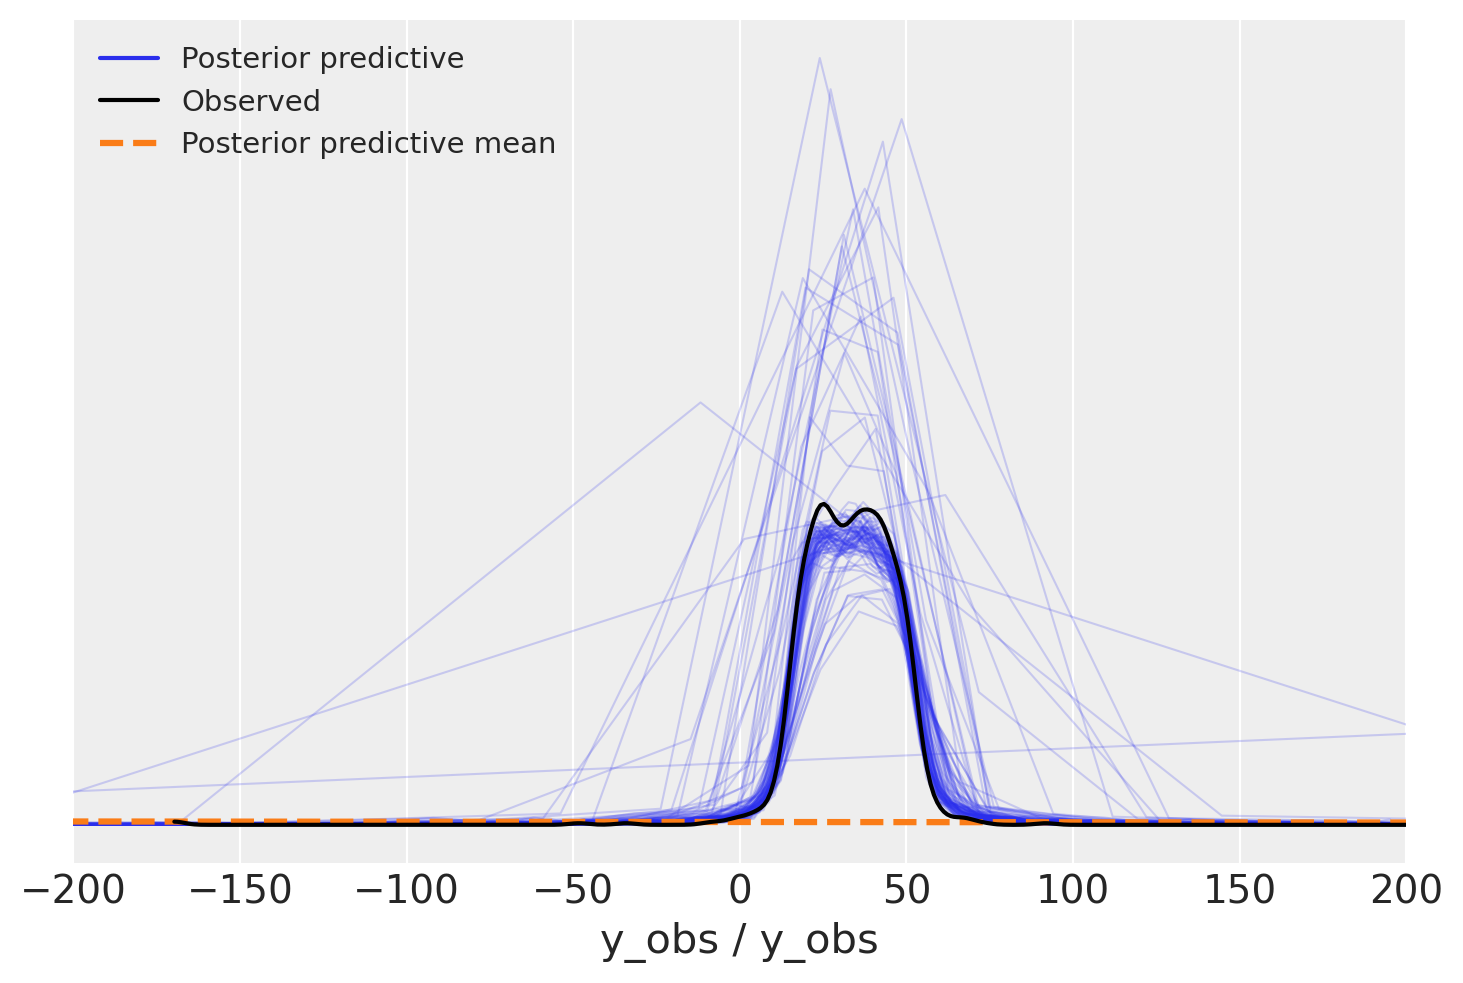

In [22]:
az.plot_ppc(overdispersed_trace, num_pp_samples=100)
plt.xlim(-200, 200);

Yes, the picture is now more accurate. In our passion to add outliers into the model, we missed the fact that we might actually add way too many of them. Variance also seems to be high, but that seems not a priority this time.

> Take-outs: reduce outliers, variance is not a priority

### Student T likelihood
> **Did you know?**
> 
> $\nu$ parameter in StudentT controls *"how heavy are the tails"*
> 
> * $\nu \to 0$ means crazy many outliers
> * $\nu = 1$ is Cauchy (See the likelihood above, gotcha)
> * $\nu \to \infty$ gives you normal distribution
> 

With StudentT distribution we can control both variance and amount of over-dispersion. How do we construct priors for parameters?
* $\nu$ - we just checked Cauchy distribution and saw that it generates tons of outliers, we need less, for sure. But not too much. We need zero avoiding prior with relatively large tails
* $\sigma$ - no specific values, we can just keep the old prior

> My take on $\nu$ parameter. I informally think of it if I would expect $1/\nu$ rate of outliers in my data. That is very aligned with $\nu \to \infty$ converging to normal distribution. Though, this is just intuition, not mathematical interpretation. Use it as long as it applies to your case.

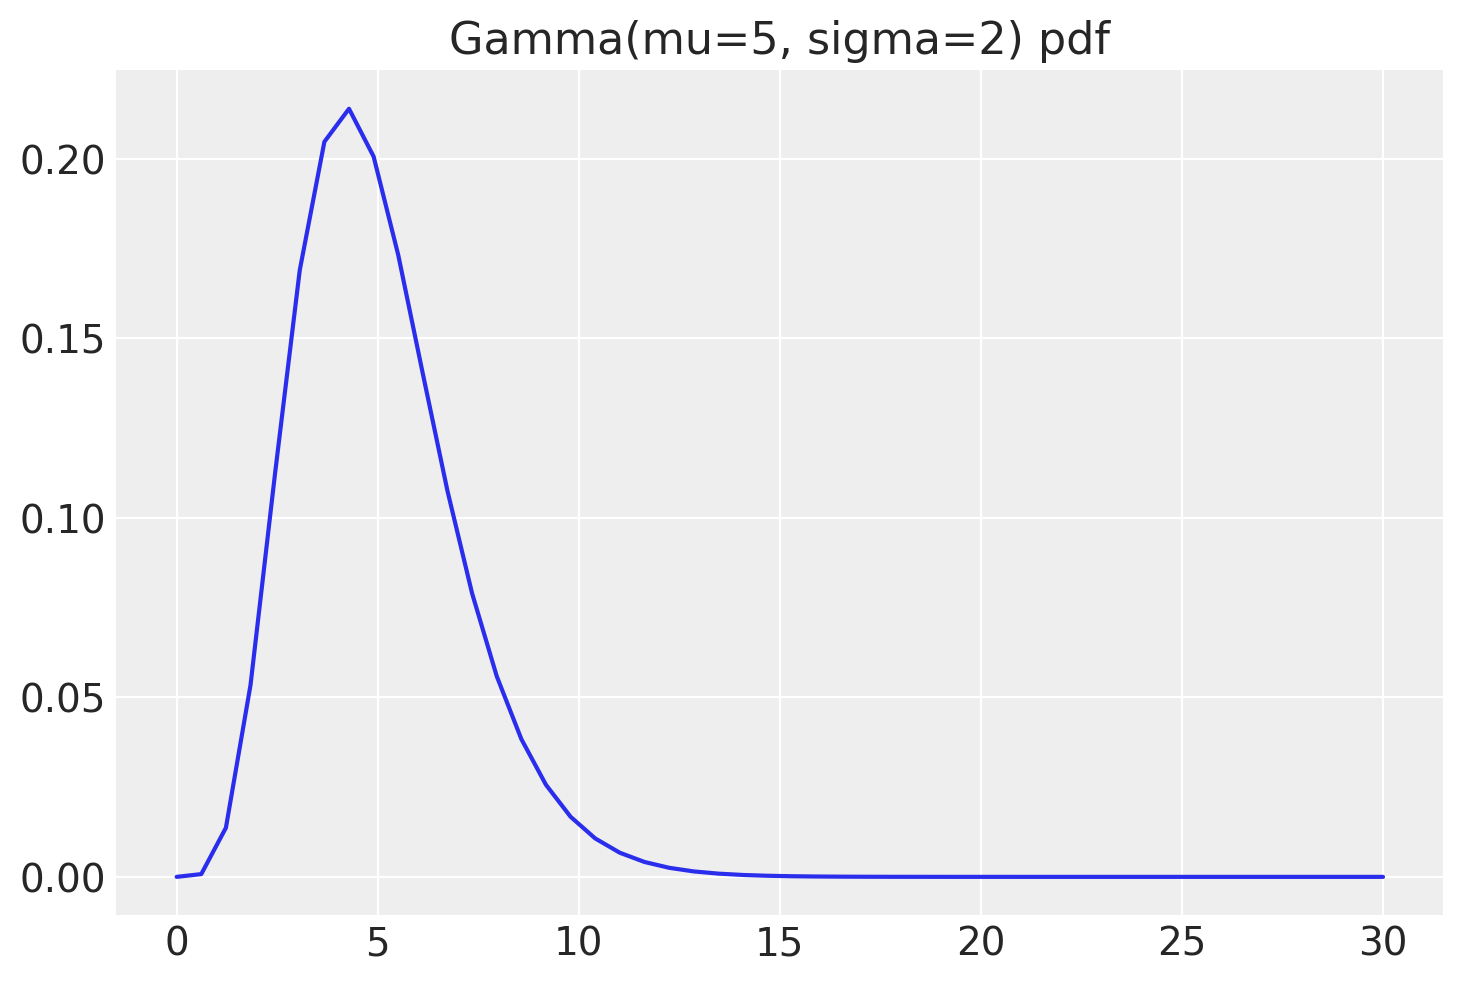

In [23]:
prior = pm.Gamma.dist(mu=5, sigma=2)
plt.plot(np.linspace(0, 30), pm.logp(prior, np.linspace(0, 30)).exp().eval())
plt.title("Gamma(mu=5, sigma=2) pdf");

In [24]:
StudentTPrior = lambda name, y, y_hat: pm.StudentT(
    name, pm.Gamma("nu", mu=5, sigma=2), 
    mu=y_hat, 
    sigma=pm.HalfNormal("sigma", 1), 
    observed=y
)

This prior should work better

In [25]:
with model(x, y, StudentTPrior) as student_model:
    student_trace = pm.sample(idata_kwargs=dict(log_likelihood=True))
    student_trace.extend(pm.sample_posterior_predictive(student_trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, intercept, nu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_obs]


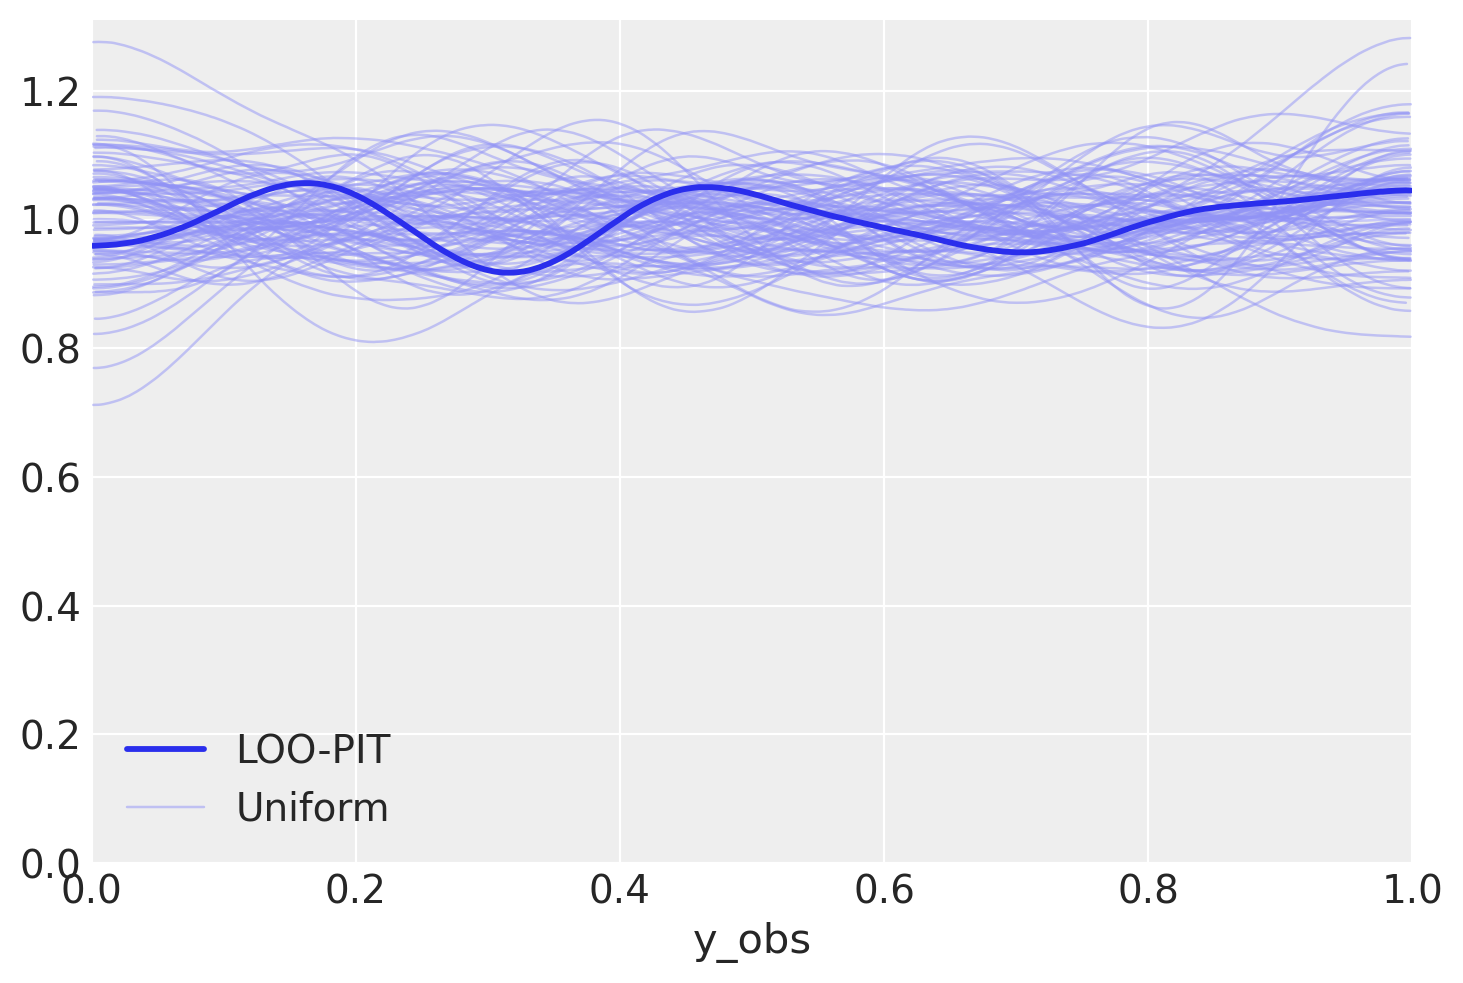

In [26]:
az.plot_loo_pit(student_trace, "y_obs");

What one looks much better. Let's compare our models...

### Model Comparison

In [27]:
summary = az.compare({
    "normal (underdispersed)": normal_trace,
    "cauchy (overdispersed)": overdispersed_trace,
    "studentT (seems nice)": student_trace,
})

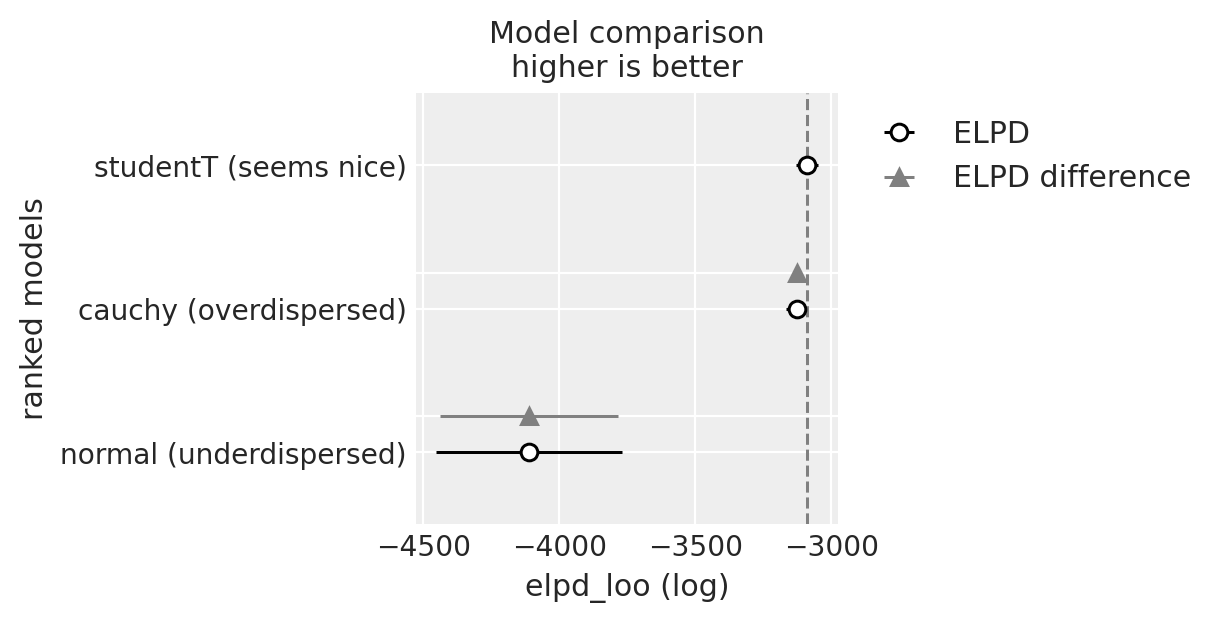

In [28]:
az.plot_compare(summary);

We see a very interesting picture. My thinking was in favor to rank the normal model higher than the Cauchy one. But things are, actually, more complicated than initially perceived. Normal distribution did not take into account outliers and suffered hard. Cauchy was more forgiving to outliers, but as we've seen, more forgiving than necessary. Does it have consequences? Probably, let's see

## Cards revealed
This all is not necessary at all unless we want to know something about our model and the system it describes. Our variables of interest are $\beta$ and the intercept:

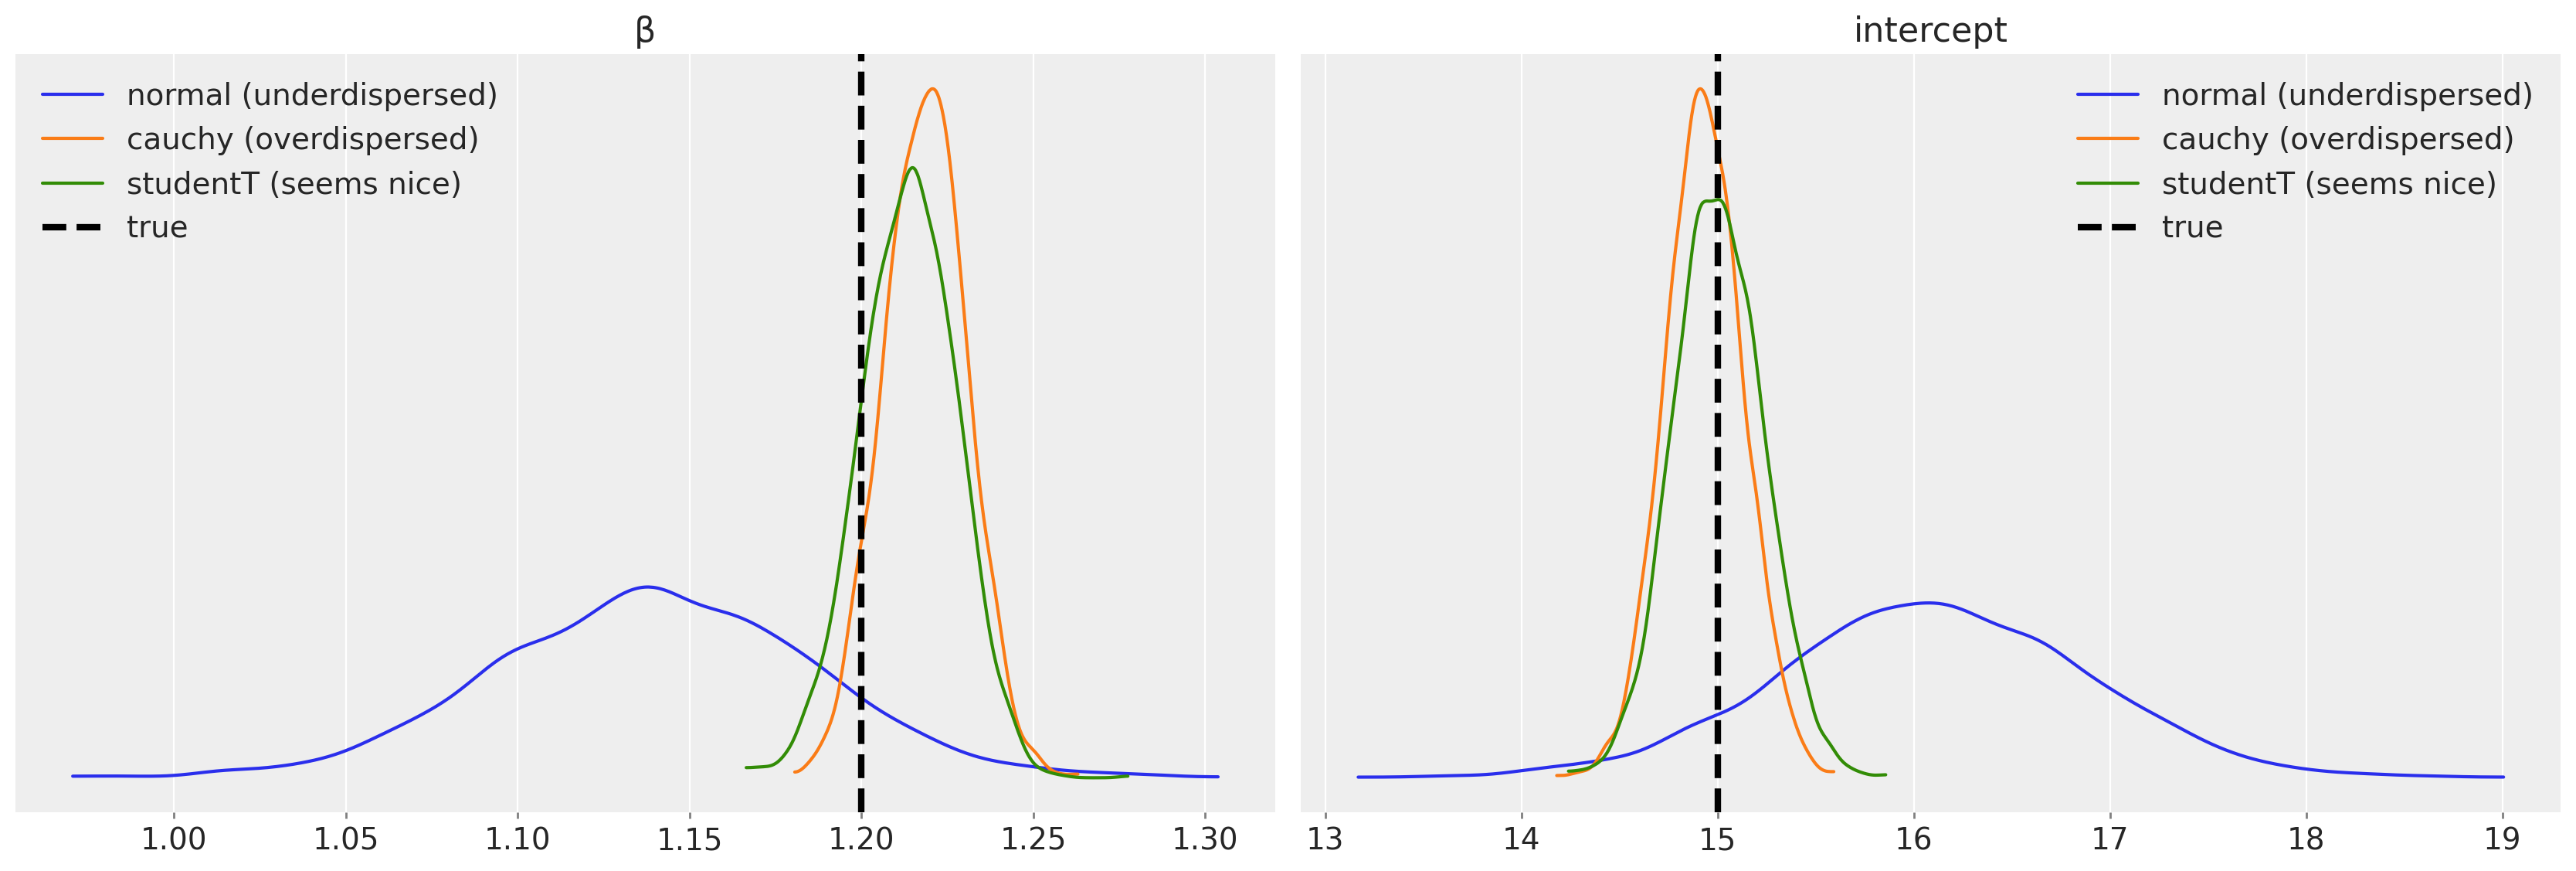

In [29]:
traces_to_plot = {
    "normal (underdispersed)": normal_trace,
    "cauchy (overdispersed)": overdispersed_trace,
    "studentT (seems nice)": student_trace,
}
ax = None
for i, (name, trace) in enumerate(traces_to_plot.items()):
    ax = az.plot_posterior(
        trace, var_names=["β", "intercept"], 
        label=name, ax=ax, color=f"C{i}", 
        point_estimate=None,
        hdi_prob="hide",
    )
ax[0].axvline(true_beta, color="black", linestyle="--", linewidth=3, label="true")
ax[0].legend()
ax[1].axvline(true_intercept, color="black", linestyle="--", linewidth=3, label="true")
ax[1].legend();

We can also compare variance (scale parameters) that our models estimate

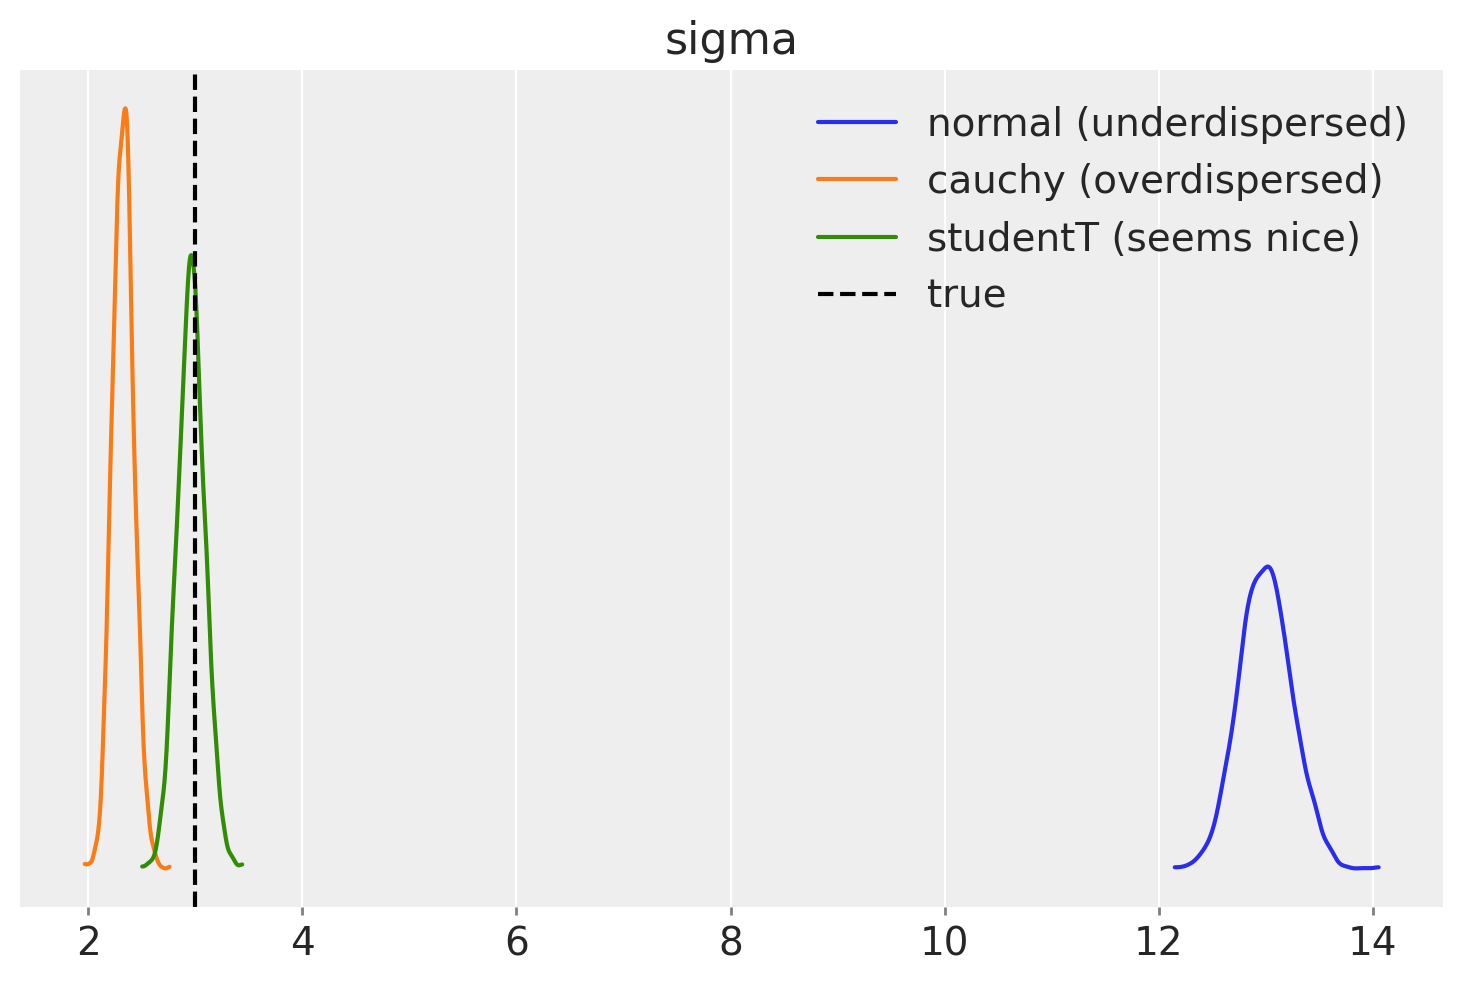

In [30]:
traces_to_plot = {
    "normal (underdispersed)": normal_trace,
    "cauchy (overdispersed)": overdispersed_trace,
    "studentT (seems nice)": student_trace,
}
ax = None
for i, (name, trace) in enumerate(traces_to_plot.items()):
    ax = az.plot_posterior(
        trace, var_names=["sigma"], 
        label=name, ax=ax, color=f"C{i}", 
        point_estimate=None,
        hdi_prob="hide",
    )
ax.axvline(true_sigma, color="black", linestyle="--", label="true");
ax.legend();

Hah, most have nothing in common with the true sigma. Only StudentT managed to recover the true sigma.

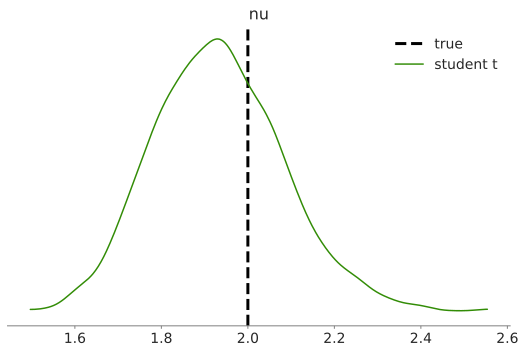

In [39]:
plt.axvline(true_nu, color="black", linestyle="--", linewidth=3, label="true")
az.plot_posterior(
    student_trace, var_names=["nu"], 
    label="student t", color=f"C{i}", 
    point_estimate=None,
    hdi_prob="hide", ax=plt.gca()
);

Posterior for $\nu$ is quite uncertain. Low values generate too much noise, so sigma is less important. The uncertainty in $\nu$ creates a lot of troubles in practice, you need to be really certain in your priors to make use of that. Let's have a look at the posterior predictive again

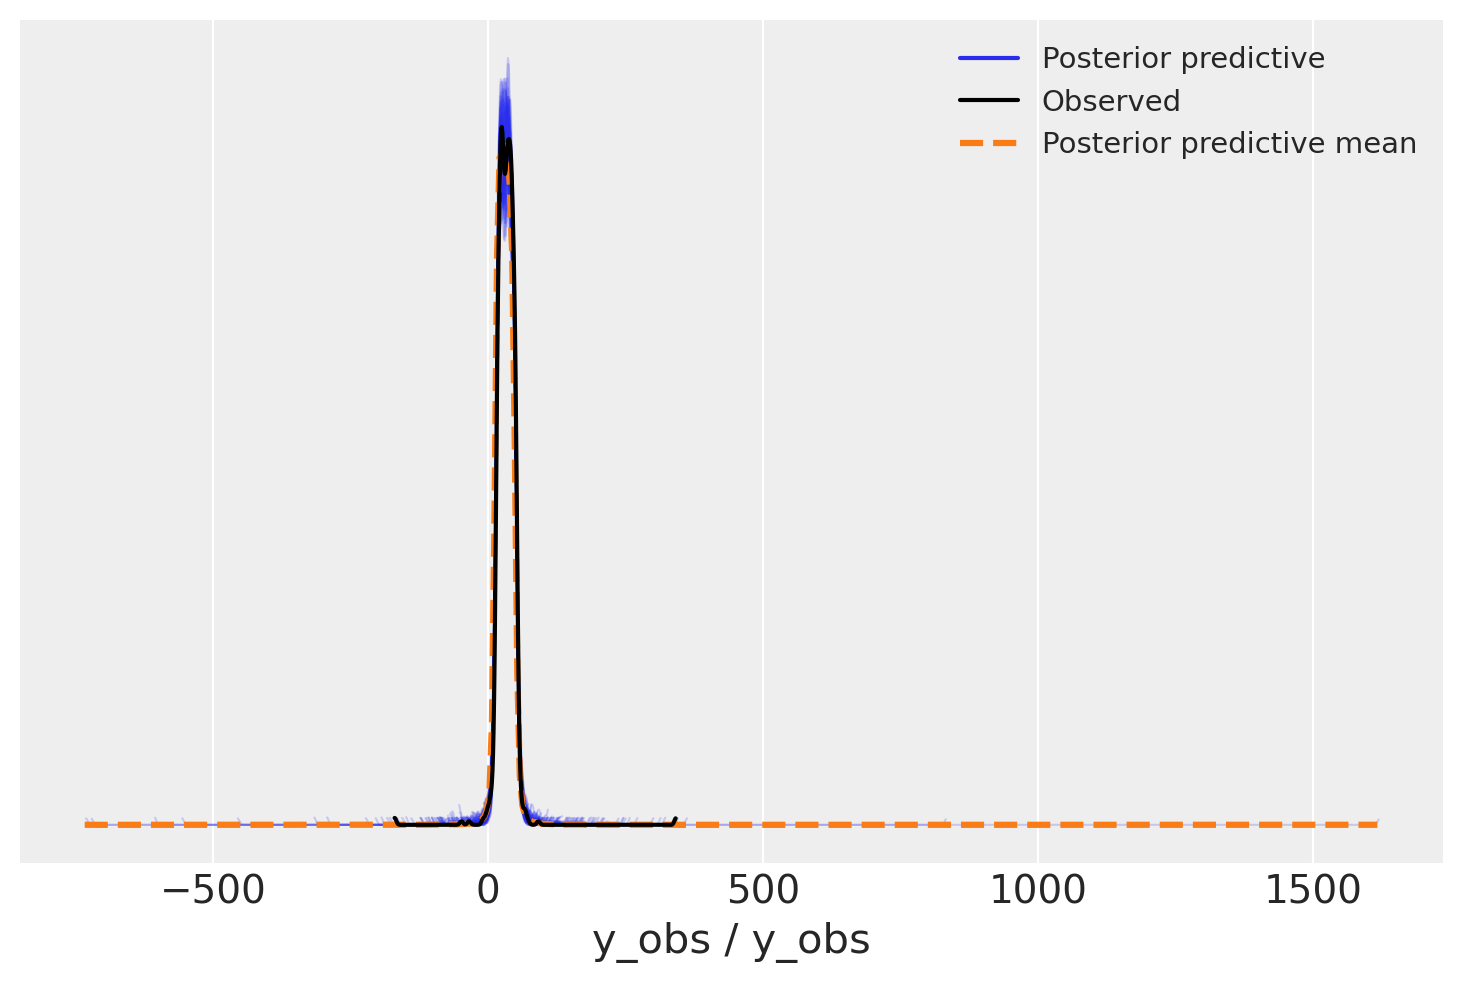

In [31]:
az.plot_ppc(student_trace, num_pp_samples=100);

We need to zoom in to see the difference

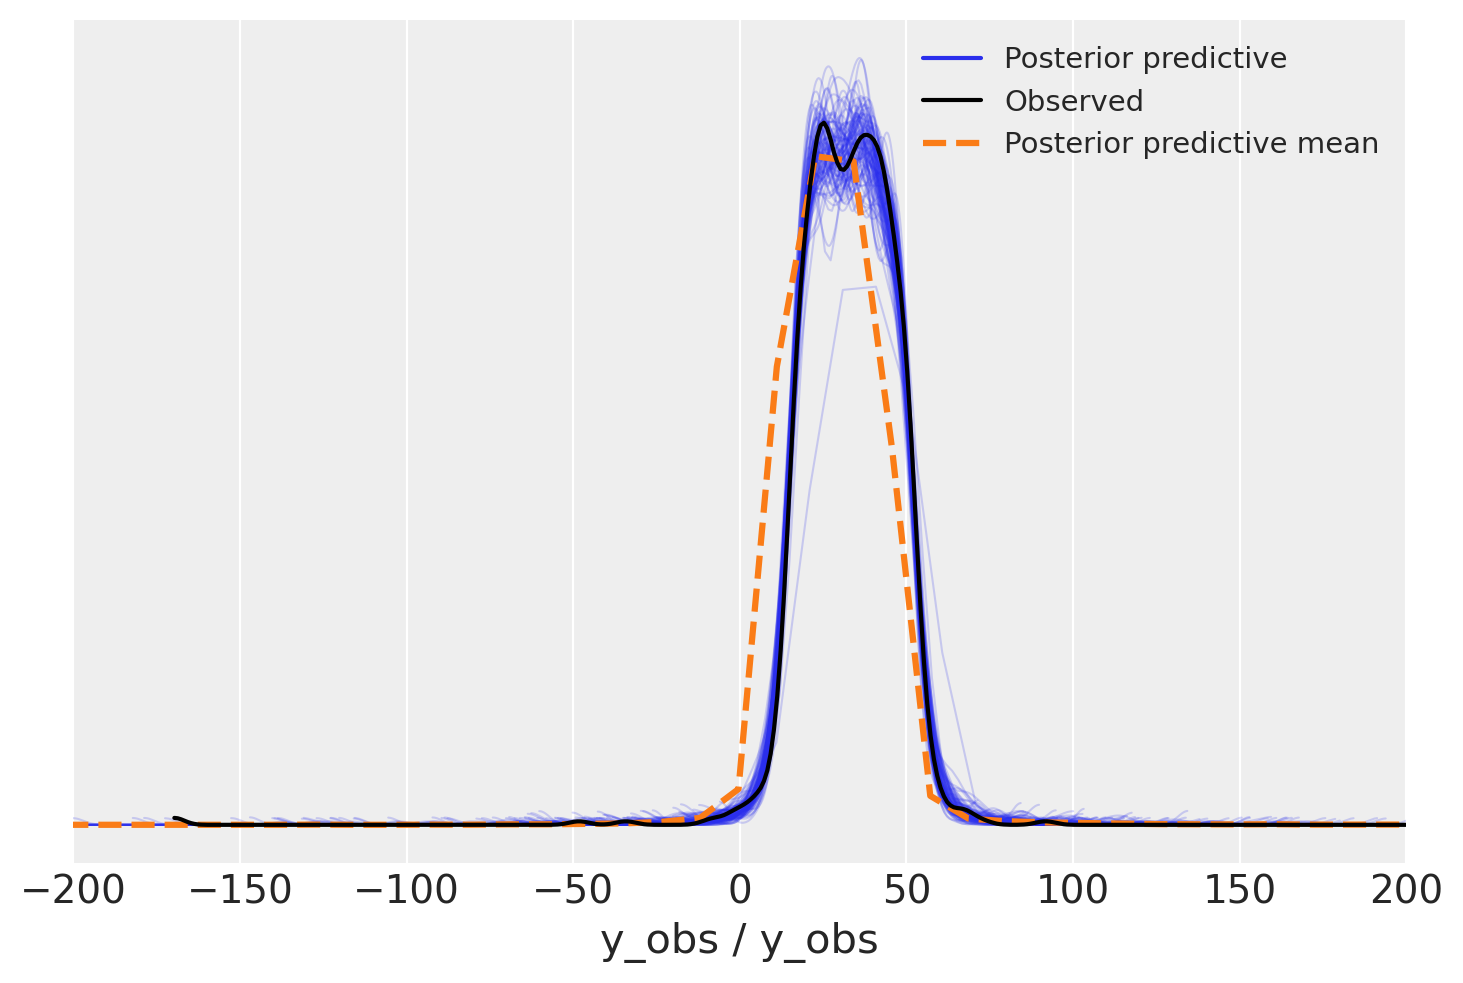

In [32]:
az.plot_ppc(student_trace, num_pp_samples=100)
plt.xlim(-200, 200);

### But could I?..

Maybe we could do any better when we know $\nu$?

In [37]:
StudentTInformedPrior = lambda name, y, y_hat: pm.StudentT(
    name, nu=true_nu, 
    mu=y_hat, 
    sigma=pm.HalfNormal("sigma", 1), 
    observed=y
)

In [40]:
with model(x, y, StudentTInformedPrior) as student_informed_model:
    student_informed_trace = pm.sample(idata_kwargs=dict(log_likelihood=True))
    student_informed_trace.extend(pm.sample_posterior_predictive(student_informed_trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_obs]


In [41]:
summary = az.compare({
    "normal (underdispersed)": normal_trace,
    "cauchy (overdispersed)": overdispersed_trace,
    "studentT (seems nice)": student_trace,
    "studentT (informed)": student_informed_trace,
})

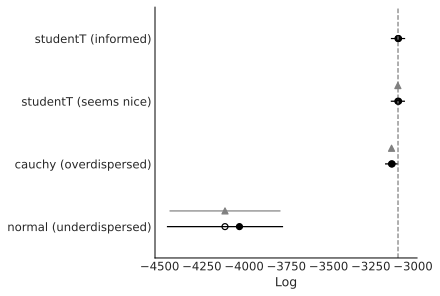

In [48]:
az.plot_compare(summary);

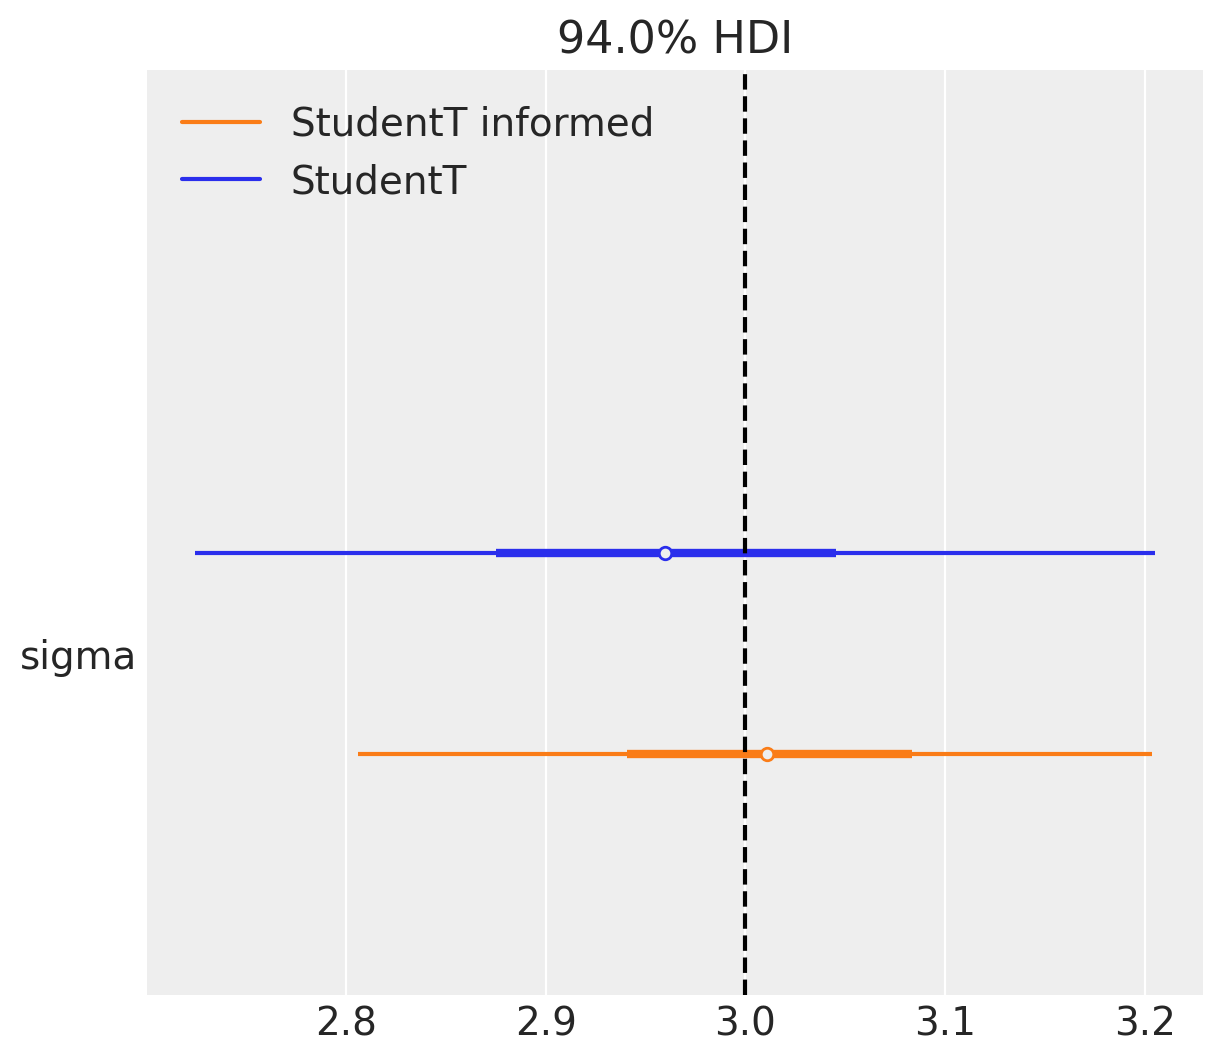

In [45]:
ax = az.plot_forest(
    [student_trace, student_informed_trace], 
    model_names=["StudentT", "StudentT informed"], 
    var_names=["sigma"], combined=True)
plt.axvline(true_sigma, color="black", linestyle="--");

Noise parameters are always tricky, there is a trade-off where there something we can infer and what is left behind the scenes. Do not get trapped in estimating every nuance parameter you ever introduce into the model. There will definitely be something you've left behind, put not informed enough priors and so on.
> Actually this is exactly the case with sigma in this example. Half normal is not zero avoiding and the true model has $\sigma=3$ that is away from zero.

# Conclusions
* LOO-PIT is a great plot that helps you to go look what is going on with the model
    * check tails and outliers
    * check variance
* LOO-PIT combined with PPC plot and LOO-Pointwise can guide to a better likelihood
* Sometimes the model gives you a good answer, but still can be improved with more informed priors, more domain knowledge. Nuance parameters are hard, and you never know the right answer, that's fine